# 入力文字列の処理

--- text2corpus
--- create_co_matrix
--- co2ppmi
--- svd


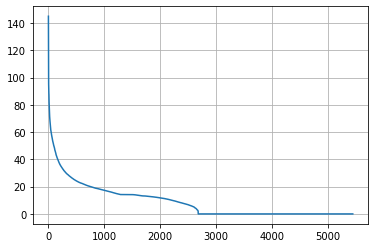

5447 [144.917 120.683 100.173  97.319  95.276  91.97   90.65   89.355  88.202
  87.591  82.646  82.108  81.811  80.945  80.023  79.2    78.548  76.155
  75.643  73.711  72.518  71.953  71.376  70.546  70.197  68.81   68.709
  68.302  67.993  67.472  67.101  66.078  64.883  64.669  64.544  64.291
  63.77   63.574  63.001  62.777  61.994  61.758  61.57   61.378  61.363
  60.906  60.547  60.338  60.181  59.792  59.607  59.391  58.754  58.683
  58.607  58.433  58.123  57.78   57.441  57.331  57.195  56.687  56.681
  56.565  56.131  56.057  55.764  55.707  55.414  55.151  54.961  54.853
  54.429  54.283  53.864  53.832  53.571  53.419  53.288  53.201  53.162
  53.007  52.686  52.618  52.152  52.018  51.905  51.676  51.653  51.319
  51.205  50.82   50.678  50.675  50.3    50.25   50.153  49.888  49.85
  49.742]
--- the ---
the : 1.0000001192092896
pg : 0.964341938495636
stony : 0.9358226656913757
sister--the : 0.9206465482711792
states' : 0.9091691374778748
success : 0.8875265121459961
1500 

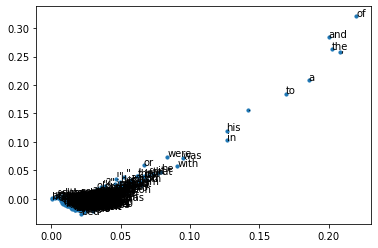

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

class WordDictionary:
    """
    受け取ったテキストを単語に分解して単語ID（整数）の配列に変換する辞書
    """
    
    def __init__(self):
        self.word2index = {}
        self.index2word = []
        self.word_count = []
        self.latest_id = 0
    
    def text2corpus(self, text):
        result = []
        for word in text.lower().replace('.', ' .').replace(',', ' ,').replace('!', ' !').replace('?', ' ?').split(' '):
            if word not in self.word2index:
                self.word2index[word] = self.latest_id
                self.index2word.append(word)
                self.word_count.append(0)
                self.latest_id += 1
            i = self.word2index[word]
            result.append(i)
            self.word_count[i] += 1
        return np.array(result)

def create_co_matrix(corpus, vocab_size, window_size=1):
    """
    コーパスの共起行列を作成する
    """
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    for i in range(corpus_size):
        for j in range(1, window_size+1):
            if i+j < corpus_size:
                co_matrix[corpus[i]][corpus[i+j]] += 1
            if 0 <= i-j:
                co_matrix[corpus[i]][corpus[i-j]] += 1
    return co_matrix

def co2ppmi(co_matrix, eps=1.0e-8):
    """
    PMI (Pointwize Mutual Information, 相互情報量)
    PPMI (Positive PMI)
    """
    cnt_each_word = co_matrix.sum(axis=0)
    cnt_total = cnt_each_word.sum()
    ppmi_matrix = np.zeros_like(co_matrix, dtype=np.float32)
    for i in range(ppmi_matrix.shape[0]):
        for j in range(ppmi_matrix.shape[1]):
            pmi = np.log2((cnt_total * co_matrix[i, j]) / (cnt_each_word[i] * cnt_each_word[j]) + eps)
            ppmi_matrix[i][j] = max(0, pmi)
    return ppmi_matrix

def similar_with(word, U, wd, num_result=10):
    """
    与えられた単語に近い単語を返す
    """
    print('--- {} ---'.format(word))
    if word not in wd.word2index:
        print('<No Result>')
    u = (U.T / np.sqrt((U * U).sum(axis=1))).T
    i = wd.word2index[word]
    result_ids = np.argsort(u.dot(u[i]))[::-1][:num_result]
    for j in result_ids:
        #print(wd.index2word[j])
        print('{} : {}'.format(wd.index2word[j], u[i].dot(u[j])))

wd = WordDictionary()

#text = 'This is a pen. I like this pen. This pen is mine.'
text = 'You say goodbye and I say hello.'
#with open('../data/nlp/sample.txt', 'r') as f:
#    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')
with open('../data/nlp/alice_in_wonderland.txt') as f:
    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')
with open('../data/nlp/christmas_carol.txt') as f:
    # Christmas Carol
    # https://www.gutenberg.org/files/46/46-0.txt
    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')

print('--- text2corpus')
corpus = wd.text2corpus(text)
print('--- create_co_matrix')
co = create_co_matrix(corpus, len(wd.index2word))
print('--- co2ppmi')
ppmi = co2ppmi(co)
print('--- svd')
U, S, V = np.linalg.svd(ppmi)

np.set_printoptions(precision=3)
#print(wd.word2index)
#print(wd.word_count)
#print(co)
#print(ppmi)
#print(U, S, V)

# 特異値の大きさの分布
s = np.array([[i, S[i]] for i in range(len(S))])
plt.plot(s[:,0], s[:,1])
plt.grid()
plt.show()
print(len(S), S[:100])


U = U[:, :20]

similar_with('the', U, wd)
similar_with('a', U, wd)
similar_with('to', U, wd)
similar_with('and', U, wd)
similar_with('where', U, wd)

ids = np.array(wd.word_count) >= 10
plt.scatter(U[ids, 0], U[ids, 1], s=10)
for i in range(ppmi.shape[0]):
    if ids[i]:
        plt.annotate(wd.index2word[i], (U[i, 0], U[i, 1]))
plt.show()

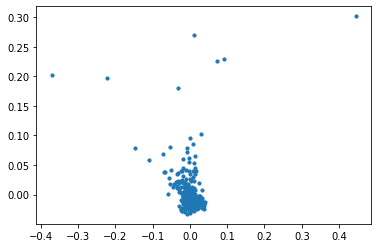

In [33]:
ids = np.array(wd.word_count) >= 10
plt.scatter(U[ids, 3], U[ids, 1], s=10)
plt.show()

### 1. 前提：特異値分解定理

$$m \times n$$ 行列

$$
A = \begin{pmatrix}
    a_{11} & \cdots & a_{1n}\\
    \vdots &  & \vdots \\
    a_{m1} & \cdots & a_{mn}\\
\end{pmatrix}
$$

に対して、$$m, n$$ 次の直行行列

$$
\begin{eqnarray}
    U = \begin{pmatrix}
        u_{11} & \cdots & u_{1m}\\
        \vdots &  & \vdots \\
        u_{m1} & \cdots & u_{mm}\\
    \end{pmatrix}
    = \left( \boldsymbol{u}_1, \cdots, \boldsymbol{u}_m \right)
    \\
    V = \begin{pmatrix}
        v_{11} & \cdots & v_{1n}\\
        \vdots & & \vdots \\
        v_{n1} & \cdots & v_{nn}\\
    \end{pmatrix}
    = \left( \boldsymbol{v}_1, \cdots, \boldsymbol{v}_m \right)
\end{eqnarray}
$$

と $$m \times n$$ 行列

$$
S = \begin{cases}
    \begin{pmatrix}
        s_1 &  & 0 \\
        & \ddots & \\
        0 &  & s_n \\
        0 & \cdots & 0 \\
        \vdots & & \vdots \\
        0 & \cdots & 0
    \end{pmatrix}
    & {\rm if} \quad m \gt n
    \\
    \begin{pmatrix}
        s_1 &  & 0 \\
        & \ddots & \\
        0 &  & s_n
    \end{pmatrix}
    & {\rm if} \quad m = n
    \\
    \begin{pmatrix}
        s_1 &  & 0 & 0 & \cdots & 0 \\
        & \ddots & & \vdots & & \vdots \\
        0 &  & s_m & 0 & \cdots & 0
    \end{pmatrix}
    & {\rm if} \quad m \lt n
\end{cases}
$$

$$
s_1 \ge s_2 \ge \cdots \ge s_{m, n}
$$

が存在し、

$$
A = USV^T
$$

### 2. 特異値分解の実行

次元削減対象の $$n$$ 次元の行ベクトル $$m$$ 個を縦に並べた行列を前節の $$A$$ に当てはめる。

（以下、ToDo）

### 3. 次元の削減

$$t$$ 次元まで削減したい場合、
- $$U'$$: $$U$$ の $$t$$ 列目までの要素を抜き出した $$m \times t$$ 行列
- $$S'$$: $$S$$ の $$t$$ 行目、$$t$$ 列目までの要素を抜き出した $$t \times t$$ 行列
- $$V'$$: $$V$$ の $$t$$ 列目までの要素を抜き出した $$n \times t$$ 行列

を用いて計算した

$$
A' \equiv U' S' V'^T
$$

を $$A$$ の近似として用いれば良い。